<a href="https://colab.research.google.com/github/droderuan/data-science-and-ml/blob/main/vai_academy/case_resolution_vaistoreipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resolução do case Vai Store
##### Curso Vai Academy
#### Realizado por: Ruan Ferreira
#### Data: 27/05/2021


### Panorama 

A área responsável pelo crescimento da empresa elaborou um plano para
manter o e-commerce como um canal relevante e de rápido crescimento mesmo após
a reabertura das lojas físicas. O plano criado consiste em 3 pilares: captar novos
clientes, aumentar a recorrência de clientes atuais e melhorar a margem das vendas.

Com os dados cedidos aos especialistas, espera-se que seja possível responder
algumas dúvidas existentes na companhia e ajudar a estruturar um plano de ação com
as três alavancas.

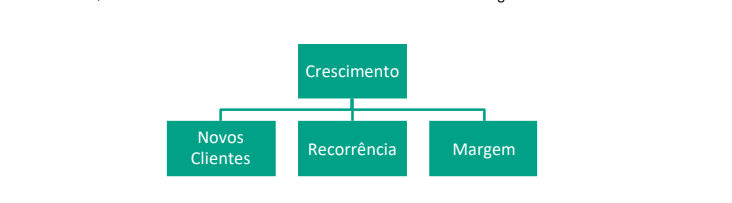

In [ ]:
import pandas as pd
import numpy as np
import sqlalchemy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from dateutil.relativedelta import relativedelta

In [ ]:
filesDir = '/content/drive/MyDrive/Colab Notebooks/vai_academy/módulo 03/case/Dados'

In [ ]:
clientOrigin = pd.read_csv(filesDir+'/ORIGEM_TRAFEGO.csv', sep=';', names=['pedido_erp', 'canal'], header=0)

mediaCosts = pd.read_excel(filesDir+'/Gasto com Mídia.xlsx', names=['date', 'facebook_ads', 'google_ads'])
mediaCosts['date'] = pd.to_datetime(mediaCosts['date'], format='%Y-%m-%d')

engine_str = f'sqlite:///{filesDir}/vaistore.sqlite'
engine = sqlalchemy.create_engine(engine_str)

In [ ]:
connection = engine.connect()

ordersToFetch = connection.execute('SELECT * FROM pedidos')
ordersResult = ordersToFetch.fetchall()

orders = pd.DataFrame(ordersResult)
orders.columns = [key.lower() for key in ordersToFetch.keys()]
orders['data_venda'] = pd.to_datetime(orders['data_venda'])
orders.sort_values('data_venda', inplace=True)

productInfoToFetch = connection.execute('SELECT * FROM info_produto')
productsInfoResult = productInfoToFetch.fetchall()

productsInfo = pd.DataFrame(productsInfoResult)
productsInfo.columns = [key.lower() for key in  productInfoToFetch.keys()]

connection.close()

> Com os arquivos fonecidos já importados, começarei a tratar de verificar as informações a fim de responder as perguntas e validar as hipóteses. Irei separar cada ponto a ser respondido e seguinte a célula, a análise.

### VISÃO GERAL
* Foi percebido um aumento substancial das vendas no e-commerce no
segundo trimestre de 2020. Analise a evolução do faturamento ao longo
dos meses.


In [ ]:
orders.head()

,data_venda,pedido,pedido_erp,cod_cliente,produto,qtde,preco_unitario,desconto_item,frete_pago_cliente,receita,custo_frete
0,2020-01-01,7000001,P10000123123,4040690,E10505Y,1,149.9,0.0,32.32,182.22,32.32
4063,2020-01-01,7000060,P10000123183,4102764,E10099Y,1,59.9,0.0,3.94,63.84,3.94
4064,2020-01-01,7000060,P10000123183,4102764,E10273Y,1,39.9,0.0,3.94,43.84,3.94
4065,2020-01-01,7000060,P10000123183,4102764,E10445Y,1,119.9,0.0,3.94,123.84,3.94
10448,2020-01-01,7000004,P10000123127,4020158,E10590Y,1,89.9,0.0,24.27,114.17,24.27


In [ ]:
# adicionando colunas indicando o trimestre e o mês/ano
def getTrimester(dateValue):
  return f'{dateValue.quarter}/{dateValue.year}'
  
def getPeriod(dateValue):
  return dateValue.strftime('%b/%Y')


In [ ]:
orders['trimestre'] = orders['data_venda'].apply(getTrimester)
orders['periodo'] = orders['data_venda'].apply(getPeriod)

In [ ]:
orders['periodo'].unique()

array(['Jan/2020', 'Feb/2020', 'Mar/2020', 'Apr/2020', 'May/2020',
       'Jun/2020', 'Jul/2020', 'Aug/2020', 'Sep/2020', 'Oct/2020',
       'Nov/2020', 'Dec/2020', 'Jan/2021', 'Feb/2021', 'Mar/2021'],
      dtype=object)

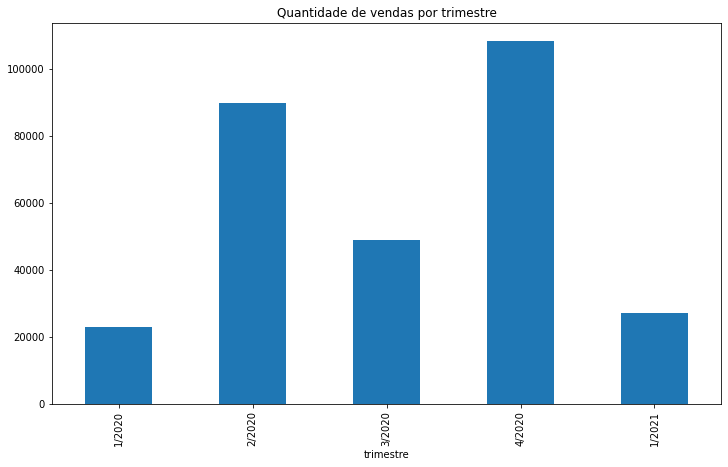

In [ ]:
plt.figure(figsize=(12,7)) 
plt.title('Quantidade de vendas por trimestre')
orders.groupby('trimestre', sort=False)['receita'].count().plot(kind='bar')
plt.show()

#### 1.a Gráfico de vendas por trimestre

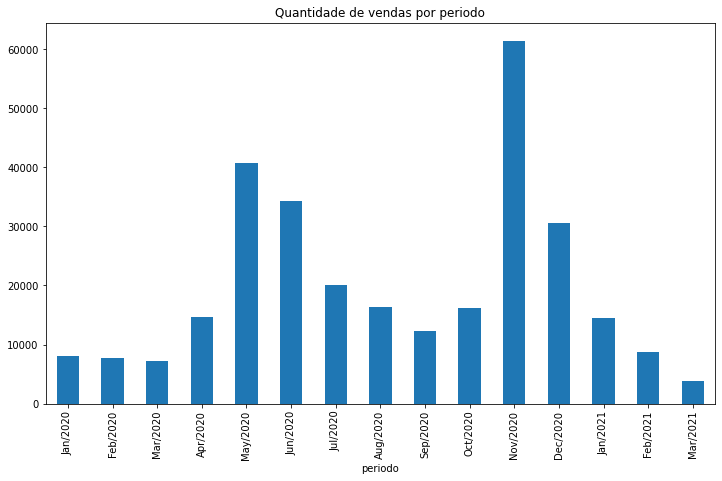

In [ ]:
plt.figure(figsize=(12,7)) 
plt.title('Quantidade de vendas por periodo')
orders.groupby('periodo', sort=False)['receita'].count().plot(kind='bar')

plt.show()

#### 1.b Gráfico de vendas por mês


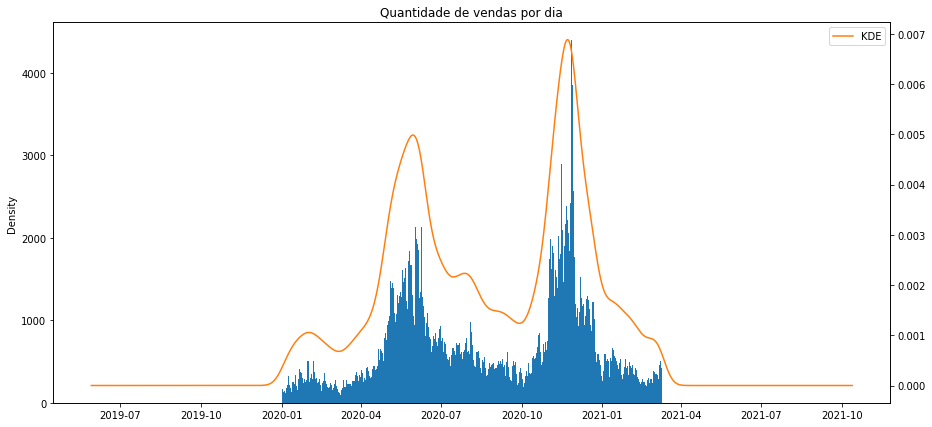

In [ ]:
plt.figure(figsize=(12,7)) 
plt.title('Quantidade de vendas por dia')
ax = orders['data_venda'].hist(bins=len(orders['data_venda'].unique()), label='Vendas por dia')
orders['ordinal'] = [date.toordinal() for date in orders['data_venda']]
orders['ordinal'].plot(kind='kde', ax=ax, secondary_y=True, label='KDE')

plt.legend(loc="upper right")
plt.show()

#### 1.c Gráfico de vendas ao longo dos dias e KDE


In [ ]:
eachTrimester = orders.groupby('trimestre')['receita'].count()
eachTrimester.div(orders['receita'].count()) * 100

trimestre
1/2020     7.743730
1/2021     9.104288
2/2020    30.230318
3/2020    16.449280
4/2020    36.472383
Name: receita, dtype: float64

Os três gráficos nos dão uma percepção melhor sobre os picos de vendas e o volume.

* Mesmo o pico de vendas para o periodo entre maio/2020 e jul/2020 ter alcançado metade em relação ao periodo de nov/2020, foi responsável por 30,23% das vendas nesses 12 meses registrado
* O pico do quarto trimestre provavelmente deve ter sido causado por alguma campanha de blackfriday

> De fato houve um aumento no volume de vendas no segundo semestre de 2020 e que, só foi ultrapassado por 6% no quarto semestre de 2020. Está relacionado ao inicio do uso do serviço Facebook Ads?



In [ ]:
mediaCosts.head()

,date,facebook_ads,google_ads
0,2020-01-01,NaN,987.46
1,2020-01-02,NaN,1165.32
2,2020-01-03,NaN,876.76
3,2020-01-04,NaN,804.85
4,2020-01-05,NaN,899.13


In [ ]:
mediaCosts['trimestre'] = mediaCosts['date'].apply(getTrimester)
mediaCosts['periodo'] = mediaCosts['date'].apply(getPeriod)

In [ ]:
# alterando a estrutura para tornar a analise mais fácil
mediaCosts = pd.melt(mediaCosts, id_vars=['date', 'trimestre', 'periodo'], value_vars=['facebook_ads', 'google_ads'], var_name='provedor', value_name='spent')

In [ ]:
mediaCosts.head()

,date,trimestre,periodo,provedor,spent
0,2020-01-01,1/2020,Jan/2020,facebook_ads,NaN
1,2020-01-02,1/2020,Jan/2020,facebook_ads,NaN
2,2020-01-03,1/2020,Jan/2020,facebook_ads,NaN
3,2020-01-04,1/2020,Jan/2020,facebook_ads,NaN
4,2020-01-05,1/2020,Jan/2020,facebook_ads,NaN


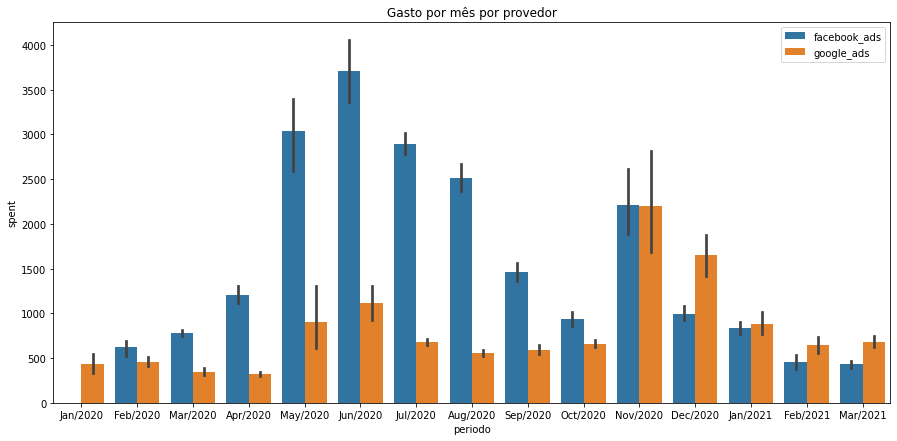

In [ ]:
plt.figure(figsize=(12,7)) 
plt.title('Gasto por mês por provedor') 
_ = sns.barplot(x="periodo", y="spent", hue="provedor", data=mediaCosts)
plt.legend(loc="upper right")
plt.show()

### 1.d Gráfico de gasto por provedor

Como pudemos ver, o gasto com ads pelo Facebook teve um salto de Abril/2020 para Maio/2020. Isso poderia ajudar a explicar esse aumento de vendas, já que os periodos combinam. Entretando ainda não podemos correlacionar o volume de vendas com o aumento de investimento no Facebook Ads.

NOVOS CLIENTES
* Um cliente é considerado ativo caso ele tenha feito compras nos últimos
12 meses. Analise a evolução do número de clientes ativos mês a mês.
* Qual o canal de marketing que mais trouxe clientes em 2020? Qual foi a
receita e margem dos clientes em cada canal? Analisando o investimento
de cada canal, qual seria a sua recomendação para a diretoria sobre a
alocação de recursos por canal?

In [ ]:
orders.head()

,data_venda,pedido,pedido_erp,cod_cliente,produto,qtde,preco_unitario,desconto_item,frete_pago_cliente,receita,custo_frete,trimestre,periodo,ordinal
0,2020-01-01,7000001,P10000123123,4040690,E10505Y,1,149.9,0.0,32.32,182.22,32.32,1/2020,Jan/2020,737425
4063,2020-01-01,7000060,P10000123183,4102764,E10099Y,1,59.9,0.0,3.94,63.84,3.94,1/2020,Jan/2020,737425
4064,2020-01-01,7000060,P10000123183,4102764,E10273Y,1,39.9,0.0,3.94,43.84,3.94,1/2020,Jan/2020,737425
4065,2020-01-01,7000060,P10000123183,4102764,E10445Y,1,119.9,0.0,3.94,123.84,3.94,1/2020,Jan/2020,737425
10448,2020-01-01,7000004,P10000123127,4020158,E10590Y,1,89.9,0.0,24.27,114.17,24.27,1/2020,Jan/2020,737425


In [ ]:
def isActive(client, df):
  filtered = df[df['cod_cliente'] == client['cod_cliente']]

  if (client['data_venda'] == filtered.iloc[0]['data_venda']):
    return False
  
  filtered = filtered[filtered['data_venda'] < client['data_venda']]

  recentMonth = client['data_venda'].month
  toVerify = filtered.iloc[-1]['data_venda'].month

  recentMonth = recentMonth +  12 if filtered.iloc[-1]['data_venda'].year < client['data_venda'].year else recentMonth

  diff = recentMonth - toVerify

  return True if diff < 12 else False

In [ ]:
clientsToVerifyActivity = orders.drop_duplicates(['cod_cliente', 'data_venda'], keep='first')
clientsToVerifyActivity['ativo'] = clientsToVerifyActivity.apply(lambda client: isActive(client, clientsToVerifyActivity), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
clientsToVerifyActivity[clientsToVerifyActivity['data_venda'].dt.year == 2020].head(20)

,data_venda,pedido,pedido_erp,cod_cliente,produto,qtde,preco_unitario,desconto_item,frete_pago_cliente,receita,custo_frete,trimestre,periodo,ordinal,ativo
0,2020-01-01,7000001,P10000123123,4040690,E10505Y,1,149.9,0.0,32.32,182.22,32.32,1/2020,Jan/2020,737425,False
4063,2020-01-01,7000060,P10000123183,4102764,E10099Y,1,59.9,0.0,3.94,63.84,3.94,1/2020,Jan/2020,737425,False
10448,2020-01-01,7000004,P10000123127,4020158,E10590Y,1,89.9,0.0,24.27,114.17,24.27,1/2020,Jan/2020,737425,False
10449,2020-01-01,7000005,P10000123126,4087442,B10138,1,24.9,0.0,0.00,24.90,0.00,1/2020,Jan/2020,737425,False
10450,2020-01-01,7000015,P10000123136,4138415,B10058G,1,29.9,-29.9,8.08,8.08,8.08,1/2020,Jan/2020,737425,False
10492,2020-01-01,7000016,P10000123137,4130183,E10079Y,1,329.9,0.0,0.00,329.90,42.89,1/2020,Jan/2020,737425,False
10493,2020-01-01,7000017,P10000123138,4124017,E10505Y,1,149.9,0.0,0.00,149.90,0.00,1/2020,Jan/2020,737425,False
10494,2020-01-01,7000023,P10000123144,4009947,E10467Y,1,29.9,0.0,10.03,39.93,10.03,1/2020,Jan/2020,737425,False
10495,2020-01-01,7000026,P10000123150,4055904,E10527Y,1,29.9,0.0,6.40,36.30,6.40,1/2020,Jan/2020,737425,False
10496,2020-01-01,7000027,P10000123151,4087434,E10431Y,1,149.9,0.0,5.00,154.90,5.00,1/2020,Jan/2020,737425,False


In [ ]:
clientsToVerifyActivity.groupby('cod_cliente').count()['preco_unitario'].sort_values()

cod_cliente
4073167     1
4094789     1
4094788     1
4094787     1
4094786     1
           ..
4021145    16
4085066    16
4005374    17
4103152    18
4059675    18
Name: preco_unitario, Length: 146333, dtype: int64

In [ ]:
clientsToVerifyActivity[clientsToVerifyActivity['cod_cliente'] == 4059675]

,data_venda,pedido,pedido_erp,cod_cliente,produto,qtde,preco_unitario,desconto_item,frete_pago_cliente,receita,custo_frete,trimestre,periodo,ordinal,ativo
4890,2020-01-08,7000973,P10000124090,4059675,E10151Y,1,39.9,-2.00,24.27,62.17,24.27,1/2020,Jan/2020,737432,False
58634,2020-05-02,7022832,P10000145551,4059675,E10377Y,1,79.9,0.00,12.81,92.71,12.81,2/2020,May/2020,737547,True
67584,2020-06-07,7055152,P10000177779,4059675,E10485Y,1,99.9,0.00,0.00,99.90,12.99,2/2020,Jun/2020,737583,True
100547,2020-06-21,7064786,P10000187372,4059675,E10150Y,1,99.9,0.00,0.00,99.90,12.99,2/2020,Jun/2020,737597,True
143958,2020-06-25,7066838,P10000189389,4059675,E10500Y,1,9.9,0.00,3.72,13.62,3.72,2/2020,Jun/2020,737601,True
107898,2020-06-30,7069111,P10000191652,4059675,E10507Y,1,69.9,0.00,25.61,95.51,25.61,2/2020,Jun/2020,737606,True
88252,2020-07-05,7071263,P10000193788,4059675,E10541Y,1,269.9,0.00,0.00,269.90,35.09,3/2020,Jul/2020,737611,True
151840,2020-07-06,7071928,P10000194478,4059675,E10655Y,1,109.9,0.00,12.14,122.04,12.14,3/2020,Jul/2020,737612,True
92478,2020-07-11,7073775,P10000196303,4059675,E10406Y,1,69.9,-6.99,0.00,62.91,9.09,3/2020,Jul/2020,737617,True
117576,2020-07-15,7075226,P10000197753,4059675,E10682Y,1,139.9,-13.99,7.45,133.36,7.45,3/2020,Jul/2020,737621,True


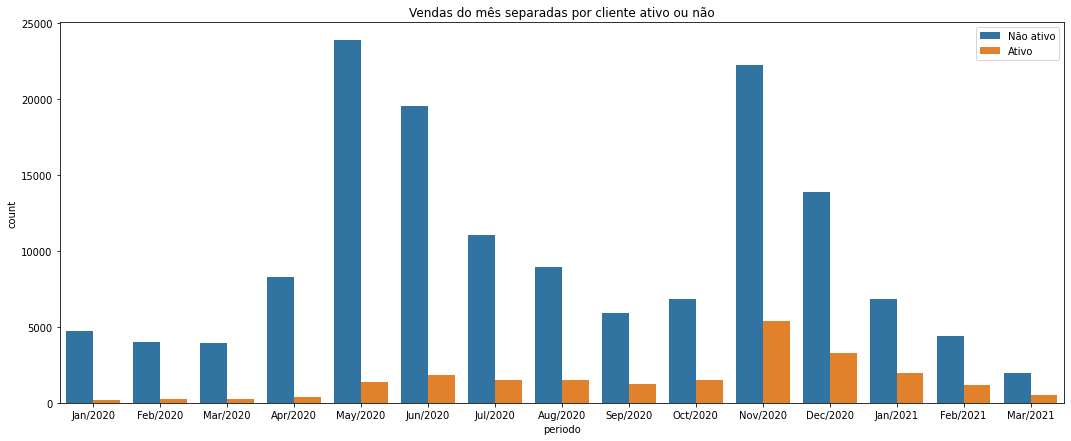

In [ ]:
con

Gráfico 

O gráfico a cima mostra das vendas, quais clientes eram considerados ativos. Esse gráfico não é acumulativo.
## Clientes ativos gastam mais por compra que não ativos?

RECORRÊNCIA
* No final de 2020, a empresa lançou um programa de fidelidade para
aumentar a recorrência dos clientes, ou seja, estimular uma nova compra
dos clientes já existentes. De acordo com os dados, é possível perceber
um aumento da participação de clientes antigos no faturamento? E na
frequência média de compras dos clientes?

MARGEM
* Analise a margem média de cada pedido. Lembrando que a margem
consiste na receita obtida no pedido menos os custos envolvidos (frete,
custo da mercadoria e impostos)
* Como última alavanca de crescimento, a companhia quer retirar de linha
os produtos que trazem menos margem e aumentar a divulgação das
linhas de produtos que são mais rentáveis. De acordo com suas análises a
partir dos dados recebidos, qual seria a sua recomendação para o time de
produtos?